# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model. 

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business. 

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:** 
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions. 

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Installing surprise library**

In [1]:
# Installing surprise library
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [2]:
# Basic python libraries
import numpy as np
import pandas as pd

# Python libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD
from collections import defaultdict

# For implementing cross-validation
from surprise.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [4]:
# Loading the datasets
data = pd.read_csv("ratings_Electronics.csv")

In [6]:
data.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [8]:
#Renaming thr header
data.columns = ['user_id', 'prod_id', 'rating', 'timestamp']
data.head()

,user_id,prod_id,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [10]:
#Copying the Dataframe to another DF
df = data.copy()
df.head()

,user_id,prod_id,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product. 

In [12]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:        
        ratings_count[user] += 1
  
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [13]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [14]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:
    
    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1
    
    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1    

In [15]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [19]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [20]:
# Check the number of rows and columns and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Write your observations here:______**

After removing the rating count for given by user less than 50 and the products with atleast 5 ratings we can observe 
1. A huge set of data is been removed.
2. There are about 65290 records in the dataset.
3. This might help us create better recomemendation models

### **Data types**

In [24]:
# Check Data types and provide observations
df_final.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

**Write your observations here:  **
1. The data type for user_id and prod_id is object.
2. The data type for prod_id is float.

### **Checking for missing values**

In [26]:
# Check for missing values present and provide observations
df_final.isnull().sum()


user_id    0
prod_id    0
rating     0
dtype: int64

**Write your observations here:______**
1. We do not have ant null or missing values in the dataset

### **Summary Statistics**

In [27]:
# Summary statistics of 'rating' variable and provide observations
df_final['rating'].describe()


count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

**Write your observations here:______**

From the above summary we can observe that the 
1. Min value is 1
2. Max is 5
3. Mean value and 25th percentage are 4 rating.
4. 75th and 50th percentage are all 5 ratings.

We can see that most of the ratings given by the users are 5.

### **Checking the rating distribution**

<Axes: xlabel='rating', ylabel='count'>

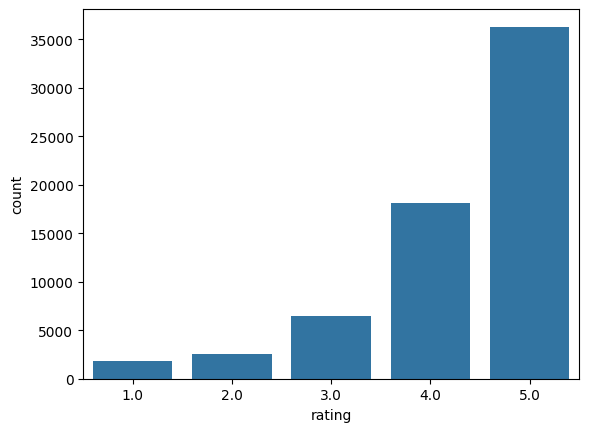

In [28]:
# Create the bar plot and provide observations
sns.countplot(x="rating", data=df_final)

**Write your observations here:________**

We can observe from the above bar graph that we have more percentage of data with 5 rating

### **Checking the number of unique users and items in the dataset**

In [40]:
# Number of total rows in the data and number of unique user id and product id in the data
unique_users = df_final['user_id'].nunique()
unique_items = df_final['prod_id'].nunique()
total_count = df_final.count()

print("Unique_user_ids =", unique_users ,  "\n\n" "Unique_items_ids =" , unique_items , "\n\n", "Total_count= \n", total_count)

Unique_user_ids = 1540 

Unique_items_ids = 5689 

 Total_count= 
 user_id    65290
prod_id    65290
rating     65290
dtype: int64


**Write your observations here:_______**

From the above data we can observe that 
1. There are only 1540 unique users out of 65290 user ratings
2. Also there are only 5689 unique item out of 65290 item ratings

### **Users with the most number of ratings**

In [57]:
# Top 10 users based on the number of ratings
max_rating_users = df_final['user_id'].value_counts().reset_index()
max_rating_users = max_rating_users.sort_values(by='count', ascending=False)

max_rating_users.head(10)

,user_id,count
0,ADLVFFE4VBT8,295
1,A3OXHLG6DIBRW8,230
2,A1ODOGXEYECQQ8,217
3,A36K2N527TXXJN,212
4,A25C2M3QF9G7OQ,203
5,A680RUE1FDO8B,196
6,A1UQBFCERIP7VJ,193
7,A22CW0ZHY3NJH8,193
8,AWPODHOB4GFWL,184
9,AGVWTYW0ULXHT,179


**Write your observations here:_______**

From the above datafrom we can see the 10 users with most number of reviews. Also the highest user review count is 295.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [119]:
# Calculate the average rating for each product 

avg_ratings = df_final.groupby('prod_id')['rating'].mean().reset_index()
avg_ratings.columns = ['prod_id', 'avg_rating']
avg_ratings


,prod_id,avg_rating
0,1400501466,3.333333
1,1400532655,3.833333
2,1400599997,4.000000
3,9983891212,4.875000
4,B00000DM9W,5.000000
...,...,...
5684,B00L21HC7A,4.625000
5685,B00L2442H0,4.916667
5686,B00L26YDA4,4.384615
5687,B00L3YHF6O,5.000000


In [120]:
# Calculate the count of ratings for each product

product_ratings_count = df_final.groupby('prod_id')['rating'].count().reset_index().sort_values('rating', ascending=False)
product_ratings_count.columns = ['prod_id', 'rating_count']
product_ratings_count

,prod_id,rating_count
4218,B0088CJT4U,206
2316,B003ES5ZUU,184
781,B000N99BBC,167
4126,B007WTAJTO,164
4180,B00829TIEK,149
...,...,...
2182,B00368CDH6,5
2185,B0036AZA6A,5
2186,B0036E8V08,5
2191,B0036QL1JY,5


In [63]:
# Create a dataframe with calculated average and count of ratings
prod_rating_agg = df_final.groupby('prod_id')['rating'].agg(['mean', 'count']).reset_index()
prod_rating_agg.columns = ['prod_id', 'average', 'count']
prod_rating_agg

,prod_id,average,count
0,1400501466,3.333333,6
1,1400532655,3.833333,6
2,1400599997,4.000000,5
3,9983891212,4.875000,8
4,B00000DM9W,5.000000,5
...,...,...,...
5684,B00L21HC7A,4.625000,16
5685,B00L2442H0,4.916667,12
5686,B00L26YDA4,4.384615,13
5687,B00L3YHF6O,5.000000,14


In [123]:
# Sort the dataframe by average of ratings in the descending order
avg_ratings_desc = avg_ratings.sort_values('avg_rating', ascending=False)
avg_ratings_desc = avg_ratings_desc.reset_index()
avg_ratings_desc

,index,prod_id,avg_rating
0,5688,B00LGQ6HL8,5.000000
1,2302,B003DZJQQI,5.000000
2,3443,B005FDXF2C,5.000000
3,5554,B00I6CVPVC,5.000000
4,4810,B00B9KOCYA,5.000000
...,...,...,...
5684,2447,B003O2RVGM,1.833333
5685,784,B000ND75C0,1.833333
5686,3990,B007C0Y7RI,1.625000
5687,3049,B004OBUFYW,1.400000


In [75]:
# See the first five records of the "final_rating" dataset
avg_ratings_desc.head(5)

,index,prod_id,average_rating
0,5688,B00LGQ6HL8,5.0
1,2302,B003DZJQQI,5.0
2,3443,B005FDXF2C,5.0
3,5554,B00I6CVPVC,5.0
4,4810,B00B9KOCYA,5.0


In [321]:
# Defining top products based on the highest average rating and minimum interactions
product_stats = df_final.groupby('prod_id')['rating'].agg(['mean', 'count']).reset_index()
product_stats = product_stats.sort_values(by=['mean', 'count'], ascending=[False, True])
product_stats = product_stats.reset_index()
product_stats = product_stats.drop(['index'], axis = 1)
product_stats

,prod_id,mean,count
0,B00000DM9W,5.000000,5
1,B00000K4KH,5.000000,5
2,B00004SY4H,5.000000,5
3,B00005AT7Y,5.000000,5
4,B000067SGI,5.000000,5
...,...,...,...
5684,B000ND75C0,1.833333,6
5685,B003O2RVGM,1.833333,12
5686,B007C0Y7RI,1.625000,8
5687,B004OBUFYW,1.400000,5


In [322]:
#Defining top n products based on the highest average rating and minimum interactions
top_ratings_min_intrac = product_stats[product_stats['count'] == 5][product_stats['mean'] == 5]
top_ratings_min_intrac = top_ratings_min_intrac.reset_index()
top_ratings_min_intrac = top_ratings_min_intrac.drop(['index'], axis = 1)
top_ratings_min_intrac

,prod_id,mean,count
0,B00000DM9W,5.0,5
1,B00000K4KH,5.0,5
2,B00004SY4H,5.0,5
3,B00005AT7Y,5.0,5
4,B000067SGI,5.0,5
...,...,...,...
142,B00HZVPD72,5.0,5
143,B00IF70QCW,5.0,5
144,B00IIEC3O6,5.0,5
145,B00KXAFYZS,5.0,5


In [327]:
# Finding products with minimum number of interactions
prod_min_interaction = df_final.groupby('prod_id')['rating'].count().reset_index()   
prod_min_interaction = prod_min_interaction.sort_values('rating', ascending=True)
prod_min_interaction = prod_min_interaction[prod_min_interaction['rating'] == 5].reset_index() 
prod_min_interaction = prod_min_interaction.drop(['index'], axis = 1)
prod_min_interaction.columns = ['prod_id', 'rating_count']
prod_min_interaction

,prod_id,rating_count
0,B00LGQ6HL8,5
1,B000WXSO76,5
2,B004WMGT1G,5
3,B000WOT6O0,5
4,B004WR125O,5
...,...,...
1077,B007RIFKUS,5
1078,B008HK3YEE,5
1079,B007RMAS1K,5
1080,B008HFCI50,5


In [115]:
#count of products with minimum number of interactions
prod_min_interaction.shape

(1082, 3)

In [335]:
# Sorting values with respect to average rating 
#reusing 'avg_ratings_desc' variable
avg_ratings_val = avg_ratings_desc.sort_values('avg_rating', ascending=True).reset_index()
avg_ratings_val.drop(['level_0','index'], axis = 1)

,prod_id,avg_rating
0,B000UF3FT8,1.375000
1,B004OBUFYW,1.400000
2,B007C0Y7RI,1.625000
3,B000ND75C0,1.833333
4,B003O2RVGM,1.833333
...,...,...
5684,B000I5LACO,5.000000
5685,B003ZTKFEE,5.000000
5686,B008R7EXCE,5.000000
5687,B00GTLN1BO,5.000000


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [316]:
#Top 5 products with 50 min interactions
#Using product_stats variable
product_ratings_top5_50 = product_stats[product_stats['count'] > 50]
product_ratings_top5_50 = product_ratings_top5_50.sort_values('mean', ascending=False)
product_ratings_top5_50.head(5)

,prod_id,mean,count
501,B001TH7GUU,4.871795,78
510,B003ES5ZUU,4.864130,184
582,B0019EHU8G,4.855556,90
716,B006W8U2MU,4.824561,57
751,B000QUUFRW,4.809524,84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [317]:
#Top 5 products with 100 min interactions 
#Using product_stats variable
product_ratings_top5_100 = product_stats[product_stats['count'] > 100]
product_ratings_top5_100 = product_ratings_top5_100.sort_values('mean', ascending=False)
product_ratings_top5_100.head(5)

,prod_id,mean,count
510,B003ES5ZUU,4.864130,184
1024,B000N99BBC,4.772455,167
1256,B007WTAJTO,4.701220,164
1288,B002V88HFE,4.698113,106
1323,B004CLYEDC,4.669492,118


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [141]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them. 

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [142]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions = model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    
    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    
    accuracy.rmse(predictions)
    
    print('Precision: ', precision) # Command to print the overall precision
    
    print('Recall: ', recall) # Command to print the overall recall
    
    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [144]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [145]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
algo_knn_model = KNNBasic(sim_options=sim_options,verbose=False, random_state = 1)


# Fit the model on the training data
algo_knn_model.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(algo_knn_model)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


**Write your observations here:**

From the Test data we can observe that
1. We can see that the RMSE value is 1.00
2. Precision and Recall value is ~0.85 where have 85% data accuracy, That is 85% of recommended products are relevent
3. The F1 score is also 0.851
4. We can try improving the model using hyperparameter tuning

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [152]:
# Predicting rating for a sample user with an interacted product
algo_knn_model.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

**Write your observations here:__________**

The Actual rating for productId 1400501466 given by the user is 5. But our prediction is 3.4 . We can still improve the performance of this model.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [171]:
# Find unique user_id where prod_id is not equal to "1400501466"
not_seen_product = df_final[~df_final['prod_id'].eq('1400501466')]['user_id'].unique()
not_seen_product
for value in not_seen_product:
    if (value == 'A34BZM6S9L7QI4'):
        print(value)


A34BZM6S9L7QI4


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.** 

In [173]:
# Predicting rating for a sample user with a non interacted product
algo_knn_model.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:__________**

From the above prediction we can see that the user 'A34BZM6S9L7QI4' predicted rating is 4.29 almost close to 5 which is a good prediction value. We can still improve the prediction by KNNBasic algorithmg.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [193]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [1, 2, 3],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }
# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.973552721050063
{'k': 40, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [194]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': True}
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized = KNNBasic(sim_options=sim_options, k=40, min_k=3, verbose=False)


# Training the algorithm on the trainset
similarity_algo_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(similarity_algo_optimized)

RMSE: 0.9590
Precision:  0.854
Recall:  0.881
F_1 score:  0.867


**Write your observations here:**
1. From the above data set we can observe that the RMSE value is reduced from ~1.00 to 0.95
2. The precision value is approx same and the recall value has increased from 0.85 to 0.88
3. The F1 score is increased from 0.856 to 0.867 which is approx 1% increase from the previous model.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [195]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
similarity_algo_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.85   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.849056603773586, details={'actual_k': 5, 'was_impossible': False})

In [197]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
similarity_algo_optimized.predict('A34BZM6S9L7QI4', '1400501466',  verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**

From the above recommendation we can see that the estimation for the user A34BZM6S9L7QI4 is  4.29 which is slightly lower than the user A3LDPF5FMB782Z with the predicted value.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [198]:
# 0 is the inner id of the above user
similarity_algo_optimized.get_neighbors(0, k=5)

[6, 42, 44, 54, 66]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [199]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended product ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')
    
    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [200]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, 'A3LDPF5FMB782Z', 5, similarity_algo_optimized)

In [201]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B00005LENO,5
1,B000067RT6,5
2,B00006HSML,5
3,B00006I53X,5
4,B00006I5J7,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**. 

In [202]:
# Declaring the similarity options
sim_option_ii = {'name': 'cosine',
               'user_based': False}
# KNN algorithm is used to find desired similar items. Use random_state=1
sim_item_item = KNNBasic(sim_options = sim_option_ii, random_state = 1, verbose = False)

# Train the algorithm on the trainset, and predict ratings for the test set
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


**Write your observations here:**

From the Test data we can observe that
1. We can see that the RMSE value is ~0.99
2. Precision and Recall value is ~83% where have 84% data accuracy, That is 83% of recomendations for the users are relevent by 84%
3. The F1 score is also 0.841
4. We can try improving the model using hyperparameter tuning

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [203]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

**Write your observations here:**

It can be observed from the above list that The Actual rating for productId 1400501466 given by the user is 5. But our prediction is 4.27 . 

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [222]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**

It can be observed from the above list that the rating for productId 1400501466 given by the user 'A34BZM6S9L7QI4' by our prediction model is 4.29. Which is better than the result for our test data. We can improve the performance of this model by hyperparameter tuning.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters 

In [226]:
# Setting up parameter grid to tune the hyperparameters
param_grid_value = {'k': [20, 40, 60], 'min_k': [4,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }
# Performing 3-fold cross validation to tune the hyperparameters
gs1 = GridSearchCV(KNNBasic, param_grid_value, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs1.fit(data)

# Find the best RMSE score
print(gs1.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs1.best_params['rmse'])

0.9692372016590932
{'k': 60, 'min_k': 4, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [227]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options1={'name': 'msd', 'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options=sim_options1, k=60, min_k=4, verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(similarity_algo_optimized_item)

RMSE: 0.9603
Precision:  0.84
Recall:  0.875
F_1 score:  0.857


**Write your observations here:**

From the Test data we can observe that
1. We can see that the RMSE value is ~0.96
2. Precision and Recall value is ~84% where have 87% data accuracy, That is 84% of recomendations for the users are relevent by 87%. Which is better than our model before tuning.
4. The F1 score is also 0.857
5. We can see that the value of the precision and recall have improved after hyperparameter tuning. 

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [209]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
similarity_algo_optimized_item.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.67   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.67427701674277, details={'actual_k': 22, 'was_impossible': False})

In [210]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
similarity_algo_optimized_item.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**

1. We can see that the test data with the rating provided better estimate than the actual prediction value for the product.
2. We do not see much difference in the prediction estimate for the product 'A34BZM6S9L7QI4' before and after hyper tuning.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [211]:
similarity_algo_optimized_item.get_neighbors(0, k=5)

[29, 53, 67, 106, 151]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [212]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations_items = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, similarity_algo_optimized_item)

In [213]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations_items, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000M2TAN4,4.812500
1,B000067RT6,4.750000
2,B004G6002M,4.708571
3,B001CIREXA,4.470588
4,B006ZP8UOW,4.400000


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [214]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)


RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


**Write your observations here:**

From the data we can observe that

1. We can see that the RMSE value is ~0.88
2. Precision and Recall value is ~85% where have 88% data accuracy, That is 85% of recomendations for the users are relevent by 88%. Which is better than our previous model.
3. The F1 score is also 0.866
4. We can see that the value of the precision and recall is better than any other model.


**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [215]:
# Making prediction
svd.predict('A3LDPF5FMB782Z', '1400501466' , r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

**Write your observations here:**

It can be observed from the above list that The Actual rating for productId 1400501466 given by the user is 5. But our prediction is 4.08 . 

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [216]:
# Making prediction
svd.predict('A34BZM6S9L7QI4', '1400501466' , verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.40037568046934, details={'was_impossible': False})

**Write your observations here:**

The Actual rating for productId 1400501466 given by the user is unknown. But our prediction is 4.4 which is better than our test case . We can still improve the performance of this model.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [217]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)


# Fitting data
gs_.fit(data)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.8991995262772695
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [218]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2, random_state=1)

# Train the algorithm on the trainset
svd_optimized=svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.8808
Precision:  0.854
Recall:  0.878
F_1 score:  0.866


**Write your observations here:**

From the data we can observe that

1. We can see that the RMSE value is ~0.88
2. Precision and Recall value is ~85% where have 87% data accuracy, That is 85% of recomendations for the users are relevent by 87%. Which is similar to our previous model.
3. The F1 score is also 0.866
4. We can see that the value of the precision and recall is similar to that of the model before tuning.


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [220]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.13   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.128589011282042, details={'was_impossible': False})

In [221]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.22   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.216280997100113, details={'was_impossible': False})

### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**

Conclusion:
1. We cleaned the data to avoid any irrelavent prediction. We took the data set for the users and products who are provided more reviews and better performing restaurants.
2. We have seen that we are able to rate the restaurants with about ~86% accuracy.
3. We have seen improvement in our model after hyperparameter tuning for all the 3 models we have build.
4. We can use collaborate filtering to provide users with top 5 restaurants suggestions.

Recommendations:
1. We can encorage other users with less number of ratings to provide ratings to the restaurants they visit.
2. We can recommend customers with the restaurants where the average rating is close to 5.
3. We can add feedback page to help restaurant to get better ratings.
4. We can provide coupons from other restaurants to customers to help them try new restaurants.